In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import cross_validation, linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

actor_full = pd.read_pickle('actor_full.pickle')

actor_data = actor_full.drop(['rank','title','studio','unadjusted_gross','actor_id'], axis=1)

# drop the NaN's
pre_drop_nans = len(actor_data)
actor_data.dropna(inplace=True)
print'Dropped %i rows with NaNs. There are %i left.' % (pre_drop_nans-len(actor_data), len(actor_data))
print '\n* * *\n'

# convert times to yearly
secs_per_year = 31622400.0
actor_data.age_on_release = actor_data.age_on_release.dt.total_seconds()/secs_per_year

for col in ['bday','release']:
    actor_data[col] = actor_data[col].dt.year

# filter out crazy erroneous stuff
# by eye looking at pre-filtered scatterplots
pre_filter_len = len(actor_data)
actor_data = actor_data[(actor_data.age_on_release < 100) 
    & (actor_data.bday > 1920) & (actor_data.release < 2016)]
print'Filtered out %i rows with impossible values. There are %i rows left.' % (
    pre_filter_len-len(actor_data), len(actor_data))
print '\n* * *\n\n'


actor_data[['bday','release','adjusted_gross','age_on_release','male_txt']].head()
# # convert datetime/timedelta to numeric
# for col in actor_data.select_dtypes(exclude=['bool']).columns:
#     print '(before)', col, '\t\t', actor_data[col].dtype
#     actor_data[col] = pd.to_numeric(actor_data[col])
#     print '(after )', col, '\t\t', actor_data[col].dtype, '\n'

/home/ian/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ian/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Dropped 663 rows with NaNs. There are 15753 left.

* * *

Filtered out 159 rows with impossible values. There are 15594 rows left.

* * *




,bday,release,adjusted_gross,age_on_release,male_txt
Aaron Eckhart,1968,2008,647761600,40.267760,1
Aaron Eckhart,1968,2000,202723200,31.948087,1
Aaron Eckhart,1968,1999,125272500,31.713115,1
Aaron Eckhart,1968,2013,105047200,44.934426,1
Aaron Eckhart,1968,2011,92481700,42.907104,1


In [2]:
# make movies_count column
actor_data['movies_count'] = actor_data.reset_index().groupby('index').adjusted_gross.apply(pd.Series.count)
actor_data[['movies_count','release','adjusted_gross','bday']].head()

,movies_count,release,adjusted_gross,bday
Aaron Eckhart,27,2008,647761600,1968
Aaron Eckhart,27,2000,202723200,1968
Aaron Eckhart,27,1999,125272500,1968
Aaron Eckhart,27,2013,105047200,1968
Aaron Eckhart,27,2011,92481700,1968


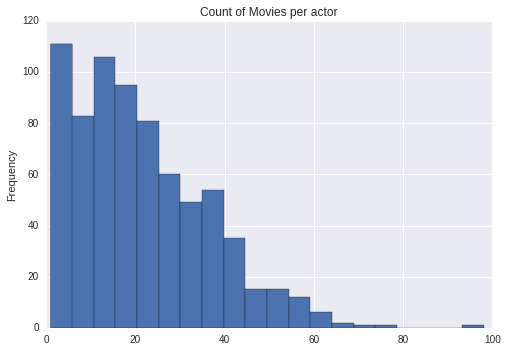

In [3]:
actor_data.reset_index().groupby('index').movies_count.first().plot.hist(
    title='Count of Movies per actor', bins=20);

In [4]:
# only include actors with over 5 movies ( <=5 means not enough data to be useful)
pre_filter_len = len(actor_data)
actor_data = actor_data[actor_data.movies_count > 5]
print 'removed %i actors, %i left' % (pre_filter_len-len(actor_data), len(actor_data))

removed 346 actors, 15248 left


In [5]:
# The convenience fn train_test_split() randomly splits X and y into train and test.
# For results to be reproducible, set the random seed
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    actor_data.drop('adjusted_gross', axis=1), 
    actor_data.adjusted_gross, 
    test_size=0.3, 
    random_state=0)

In [6]:
lasso_model = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=2000)
lasso_model.fit(X_train, y_train)

/home/ian/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=2000, n_alphas=100, n_jobs=2, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [7]:
def make_coef_df(model, X_train, y_train, significance_thresh=0.1):
    print 'alpha (aka lambda) for model: %f' % model.alpha_
    print 'intercept for model: %f' % model.intercept_
    print 'R-squared (unadjusted??) of model on training set:', model.score(X_train, y_train)

    significant_columns = np.where(abs(model.coef_) > significance_thresh)[0]
    
    print '\ngot %i significant columns (>%f) out of %i' % (
        len(significant_columns), significance_thresh, len(model.coef_))

    coef_df = pd.DataFrame(
        [(model.coef_[idx], X_train.columns[idx]) for idx in significant_columns], 
        index=significant_columns, columns=['coef','col_name'])

    # sort coefficients by absolute value
    coef_df = coef_df.loc[coef_df.coef.abs().sort_values(ascending=False).index]
    return coef_df

# top 20
coef_df = make_coef_df(lasso_model, X_train, y_train)
coef_df.head(20)

alpha (aka lambda) for model: 10375.347788
intercept for model: 1315062122.329385
R-squared (unadjusted??) of model on training set: 0.0544049727526

got 116 significant columns (>0.100000) out of 344


,coef,col_name
172,34188095.318998,English male child actors
84,30897894.495698,Use mdy dates from June 2011
20,24230243.109227,Wikipedia indefinitely semi-protected biograph...
110,-20056339.388722,Use mdy dates from September 2015
105,18568371.910649,Australian male film actors
277,16854531.991481,Articles with unsourced statements from Decemb...
99,16742073.502235,Hispanic and Latino American actresses
116,16680948.322260,American women film directors
294,15254111.565079,Kennedy Center honorees
214,13077714.391268,English male voice actors


In [8]:
for interest in ['bday','age_on_release', 'male_txt', 'People from Manhattan']:
    idx = X_train.columns.get_loc(interest)
    print idx, interest, lasso_model.coef_[idx]

33 bday -205022.990715
342 age_on_release 0.0
341 male_txt 0.0
287 People from Manhattan -8648321.98533


In [9]:
coef_df[coef_df.col_name.isin(['bday','age_on_release','release','male_txt'])]

,coef,col_name
0,-427699.012049,release
33,-205022.990715,bday


**...Age on release, or maleness isn't seen as significant by Lasso when aggregating everything**

In [10]:
# most positive betas
coef_df.sort_values('coef', ascending=False).head(10)

,coef,col_name
172,34188095.318998,English male child actors
84,30897894.495698,Use mdy dates from June 2011
20,24230243.109227,Wikipedia indefinitely semi-protected biograph...
105,18568371.910649,Australian male film actors
277,16854531.991481,Articles with unsourced statements from Decemb...
99,16742073.502235,Hispanic and Latino American actresses
116,16680948.322260,American women film directors
294,15254111.565079,Kennedy Center honorees
214,13077714.391268,English male voice actors
67,12829019.319916,American Christians


In [11]:
# most negative betas
coef_df.sort_values('coef').head(10)

,coef,col_name
110,-20056339.388722,Use mdy dates from September 2015
65,-12253856.072626,Yale University alumni
74,-11834316.390811,Articles with unsourced statements from May 2015
328,-11830528.634873,Pages with citations having bare URLs
305,-11720998.895737,American female singer-songwriters
306,-9908554.886785,Articles with unsourced statements from July 2015
120,-9319763.522281,Best Supporting Actor Academy Award winners
108,-8752181.973462,American feminists
287,-8648321.985331,People from Manhattan
282,-7666695.599810,1974 births


**Try a much simpler model**

In [12]:
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(
    actor_data[['bday','age_on_release','male_txt']], 
    actor_data.adjusted_gross, 
    test_size=0.3, 
    random_state=0)

lasso_model2 = linear_model.LassoCV(n_jobs=2, normalize=True)
lasso_model2.fit(X_train2, y_train2)

coef_df2 = make_coef_df(lasso_model2, X_train2, y_train2, significance_thresh=0)
coef_df2.head(20)

alpha (aka lambda) for model: 62.124735
intercept for model: 1629537032.192250
R-squared (unadjusted??) of model on training set: 0.00638561209674

got 3 significant columns (>0.000000) out of 3


,coef,col_name
2,9122174.914955,male_txt
0,-783769.317682,bday
1,-576133.826662,age_on_release


**Exploratory plots**

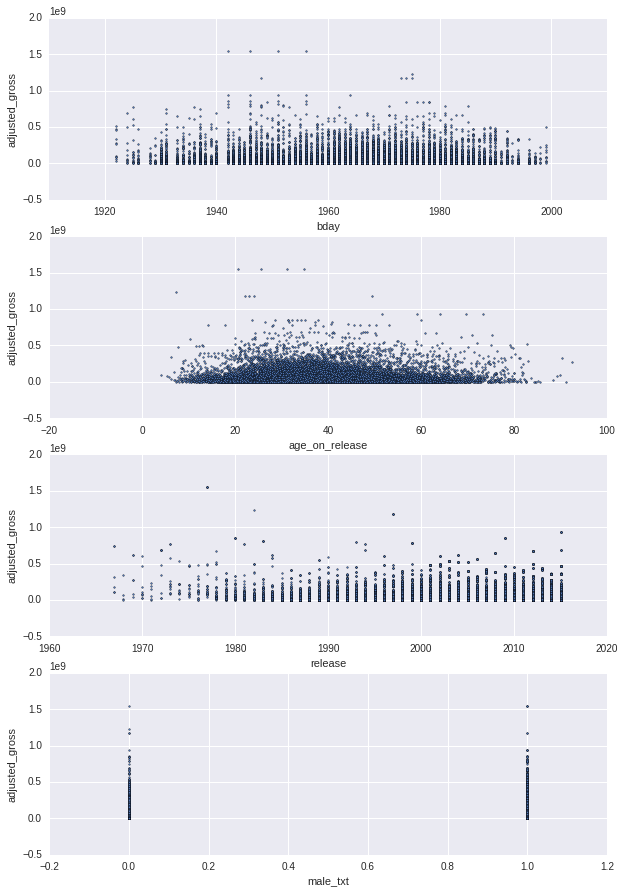

In [13]:
cols_to_plot = ['bday','age_on_release','release','male_txt']

plt.figure(figsize=(10,15))

for idx, col in enumerate(cols_to_plot):
    ax = plt.subplot(len(cols_to_plot),1,idx+1)
    plt.xlabel(col)
    actor_data.plot.scatter(col, 'adjusted_gross', ax=ax, s=3)

Count: 10201 males, 5047 females
Male   mean adj gross: 77640367
Female mean adj gross: 65034850
men gross 12605516 more than women (diff of means)


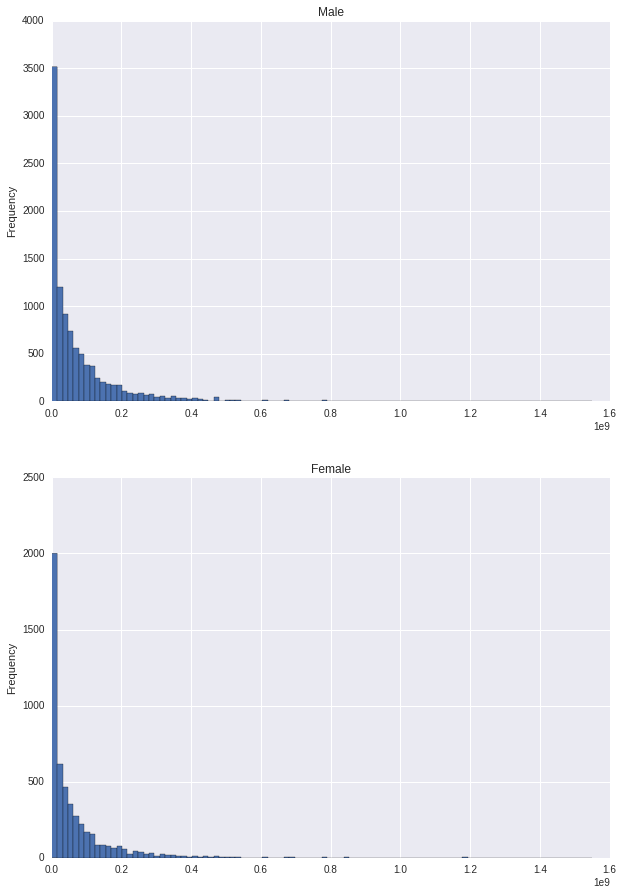

In [14]:
no_bins = 100
plt.figure(figsize=(10,15))

males_adj_gross = actor_data[actor_data.male_txt==1].adjusted_gross
females_adj_gross = actor_data[actor_data.male_txt==0].adjusted_gross

print 'Count: %i males, %i females' % (len(males_adj_gross), len(females_adj_gross))
print 'Male   mean adj gross: %i\nFemale mean adj gross: %i' % (males_adj_gross.mean(), females_adj_gross.mean())
print 'men gross %i more than women (diff of means)' % (males_adj_gross.mean() - females_adj_gross.mean())
ax = plt.subplot(2,1,1)
males_adj_gross.plot.hist(bins=no_bins, title='Male')

ax = plt.subplot(2,1,2)
females_adj_gross.plot.hist(bins=no_bins, ax=ax, title='Female')

plt.plot();

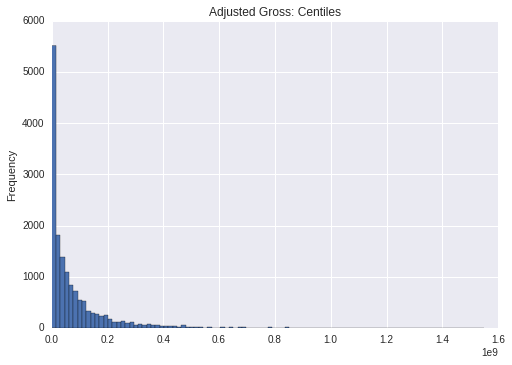

In [15]:
actor_data.adjusted_gross.plot.hist(bins=100)
plt.title('Adjusted Gross: Centiles');

min:4
max:92
mean:38


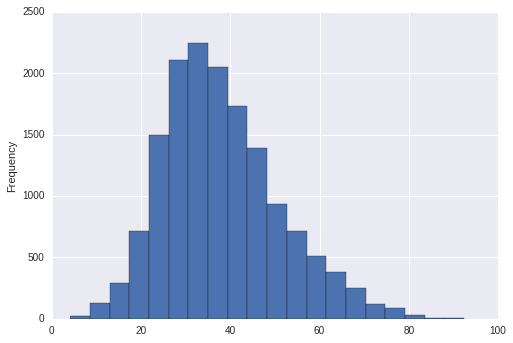

In [16]:
print 'min:%i\nmax:%i\nmean:%i' % (
    actor_data.age_on_release.min(), actor_data.age_on_release.max(), actor_data.age_on_release.mean())

actor_data.age_on_release.plot.hist(bins=20);

women median age on movie release 31
men median age on movie release  38
* * * 
women mean age on movie release 33
men mean age on movie release  40



Distribution of actor ages on movie release date by gender


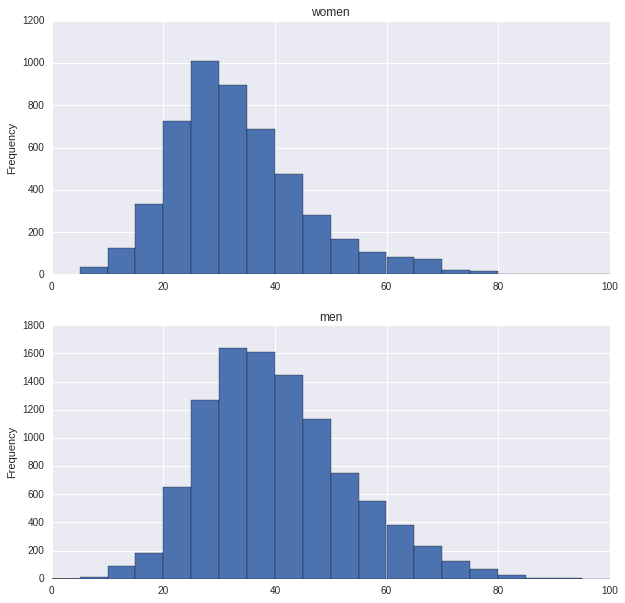

In [43]:
women = actor_data[actor_data.male_txt == 0].age_on_release
men = actor_data[actor_data.male_txt == 1].age_on_release

print 'women median age on movie release %i\nmen median age on movie release  %i' % (women.median(), men.median())
print '* '*3
print 'women mean age on movie release %i\nmen mean age on movie release  %i' % (women.mean(), men.mean())
print '\n\n'
print 'Distribution of actor ages on movie release date by gender'

plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
women.plot.hist(bins=20, ax=ax, title='women', range=[0,100])
ax = plt.subplot(2,1,2)
men.plot.hist(bins=20, ax=ax, title='men', range=[0,100]);

**Try polynomial features on age/date**

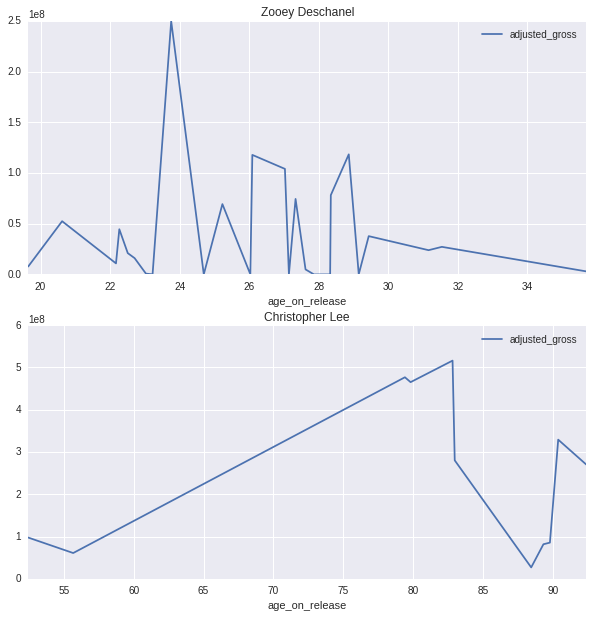

In [44]:
def plot_age_curve(actor_names, figsize=(10,10)):
    """df is a dataframe with actor data, indexed by actor name"""
    plt.figure(figsize=figsize)
    
    if isinstance(actor_names, str):
        actor_names = [actor_names]
    
    for idx, actor_name in enumerate(actor_names):
        ax = plt.subplot(len(actor_names), 1, idx+1)
        fig = actor_data.loc[actor_name].groupby('age_on_release', as_index=False).sum().plot(
            x='age_on_release', y='adjusted_gross', title=actor_name, ax=ax)
    
    return ax

plot_age_curve(['Zooey Deschanel','Christopher Lee']);

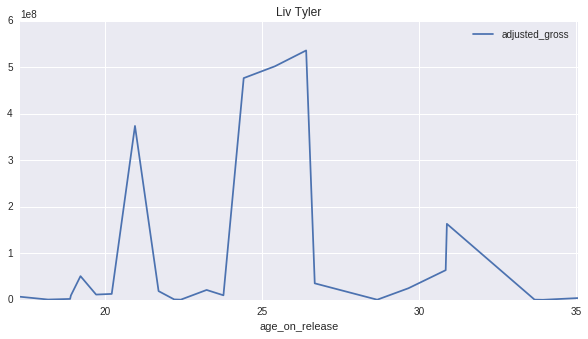

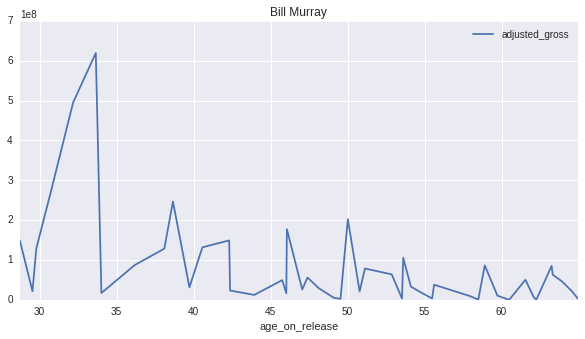

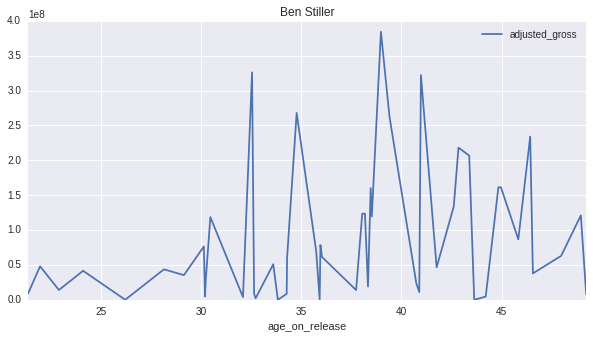

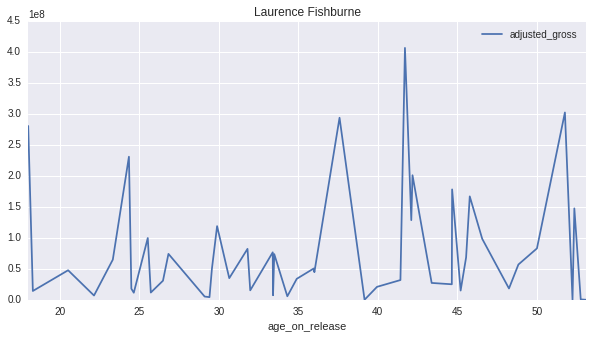

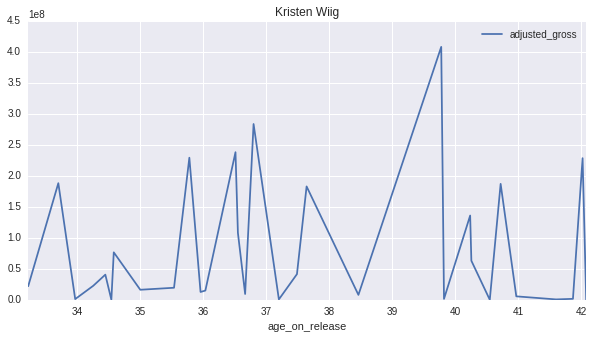

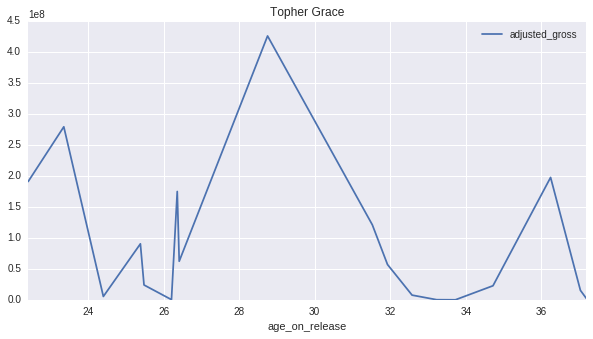

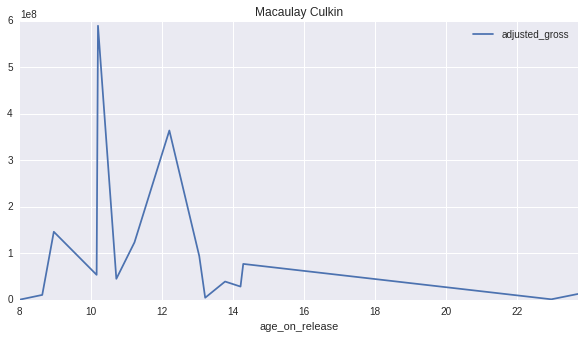

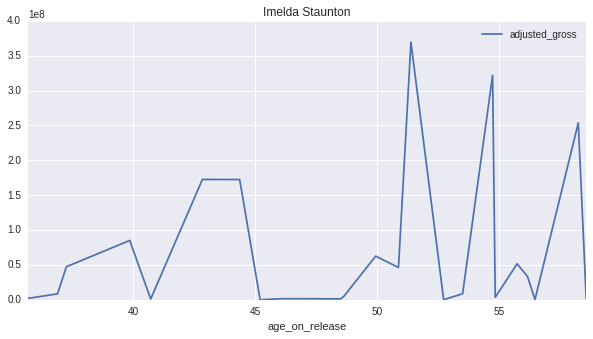

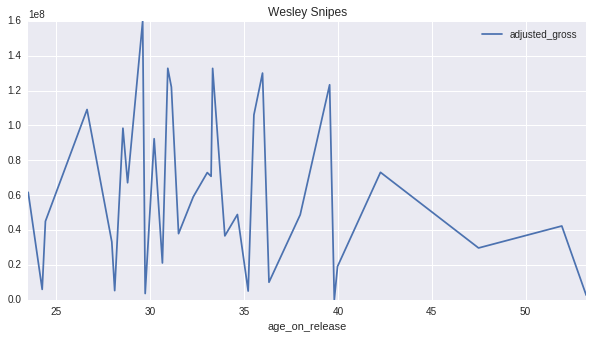

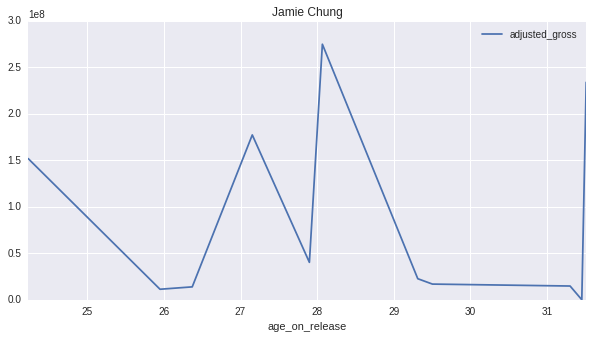

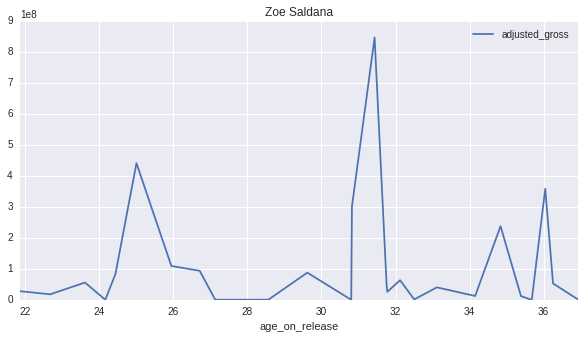

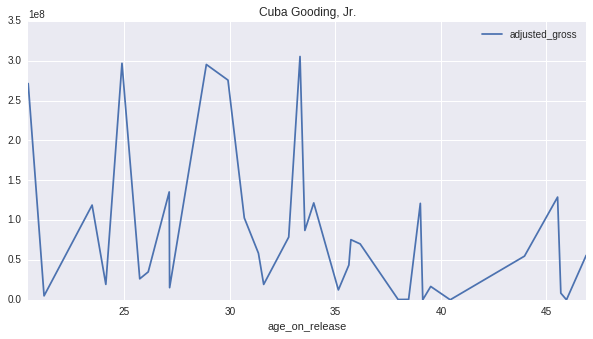

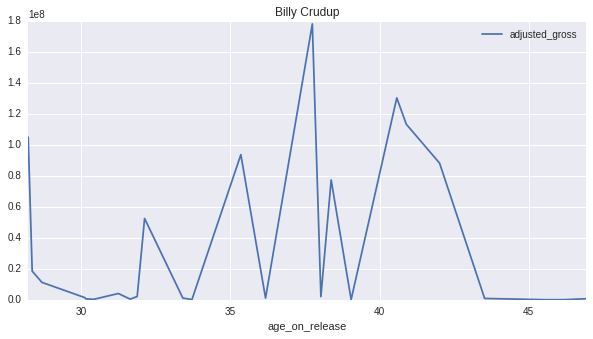

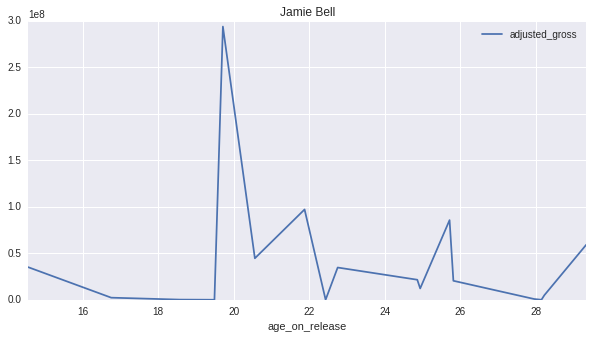

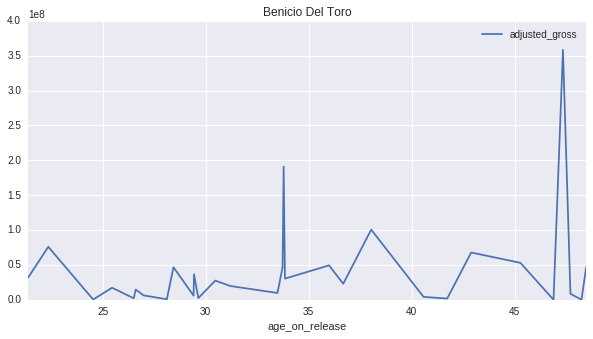

In [45]:
# plot some random age curves
for name in np.random.choice(actor_data.index.unique(), size=15, replace=False):
    plot_age_curve(name, figsize=(10,5))

In [19]:
poly_features = ['bday','age_on_release','release','male_txt']

X_train3, X_test3, y_train3, y_test3 = cross_validation.train_test_split(
    actor_data[poly_features], 
    actor_data.adjusted_gross, 
    test_size=0.3, 
    random_state=0)

poly_lasso = make_pipeline(PolynomialFeatures(), 
    linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=5000))

poly_lasso.fit(X_train3, y_train3)

lasso3 = poly_lasso.get_params()['lassocv']
poly_feat3 = poly_lasso.get_params()['polynomialfeatures']

print lasso3.coef_
print poly_feat3.powers_

[  0.00000000e+00  -5.54233378e+05   6.47578025e+05  -1.41137223e+07
   0.00000000e+00   2.36092078e+03   4.68071771e+03   1.36417908e+03
   1.07544358e+03   5.97562100e+03   6.96963433e+02   2.00188540e+05
  -2.51556627e+02   1.45754173e+01   0.00000000e+00]
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [2 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [0 2 0 0]
 [0 1 1 0]
 [0 1 0 1]
 [0 0 2 0]
 [0 0 1 1]
 [0 0 0 2]]


In [20]:
def get_poly_labels(labels, poly_obj):
    final_labels = []
    separator = '__'
    for power_list in poly_obj.powers_:
        s = ''
        for label, power in zip(labels, power_list):
            if power != 0:
                s += "%s_p%i%s" % (label, power, separator)
        if s == '':
            final_labels.append('1')
        else:
            final_labels.append(s[:-len(separator)])
    
    return final_labels
        
poly_labels = get_poly_labels(poly_features, poly_feat3)
pd.DataFrame(zip(poly_labels, list(lasso3.coef_)), columns=['feature','coef']).sort_values('coef', ascending=False)

,feature,coef
2,age_on_release_p1,647578.025351
11,age_on_release_p1__male_txt_p1,200188.540460
9,age_on_release_p2,5975.621000
6,bday_p1__age_on_release_p1,4680.717711
5,bday_p2,2360.920780
7,bday_p1__release_p1,1364.179080
8,bday_p1__male_txt_p1,1075.443575
10,age_on_release_p1__release_p1,696.963433
13,release_p1__male_txt_p1,14.575417
0,1,0.000000


In [21]:
print 'score:'
poly_lasso.score(X_train3, y_train3)

score:


0.0094624548121163832